In [1]:
%%file Rouwenhorst.m
function [Z, PI] = Rouwenhorst(rho, sigmas, znum)

% Creates a discrete approximation to a first order autoregressive process
% with serial correlation p + q - 1.  See Rouwenhorst (1995) (pps. 325-329)
% in Cooley <i>Frontiers of Business Cycle Research</i> Princeton.

if (nargin < 3)	% default is 2x2 transition matrix
	znum = 2;
end 

p = (rho + 1)/2;
q = p;

hlag = 1; h = [];

for i = 2:1:znum
	vec0 = zeros(i-1,1);
	h = p*[hlag vec0; vec0' 0] + (1-p)*[vec0 hlag; 0 vec0'] + ...
	 	(1- q)*[vec0' 0; hlag vec0] + q*[0 vec0'; vec0 hlag];
	h(2:i-1,:) = h(2:i-1,:)./2; hlag = h;
	
end

PI = h;

% symmetrically and evenly spaced between [-epsilon, epsilon] with h elements.  
% When p = q, then then variance of shock is epsilon^2/(h-1).  
zvar = (sigmas^2)/( 1 - rho^2);
epsilon = sqrt((znum - 1)*zvar);

Z = linspace(-epsilon, epsilon, znum)';

Created file '/home/takeki/Dropbox/chapter8/MATLAB/Rouwenhorst.m'.


In [2]:
%%file HH_opt_EGM.m
function [pf_c pf_n pf_sav] = HH_opt_EGM(beta,p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c_init,pf_n_init,pf_sav_init)

    %
    pf_c = pf_c_init;
    pf_n = pf_n_init;
    pf_sav = pf_sav_init;

    % WHILE LOOP: iterate until the policy functions converge.
    for EGM_iter = 1:p.MAX_EGM_ITER

        pf_c_int = zeros(p.N_A+1,p.N_Z);
        endog_grid_a = zeros(p.N_A+1,p.N_Z);

        % Assuming that the borrowing constraint is not binding, solve for the policy functions.
        for i_z = 1:p.N_Z % Fix z

            zToday      = grid_z(i_z);
            cond_prob_z = prob_z(i_z,:);

            for i_a = 1:p.N_A

                % EGM: construct a grid for a', rather than a grid for a.
                %     solve for the value of a that would have led to the choice a'.
                aTomorrow = grid_a(i_a);

                % Compute the expected marginal utility of consumption using a', and derive consumption today from the Euler equation.
                % Note that here we skip a root-finding algorithm, thereby making the algorithm much more efficient than the usual policy function iteration!
                EMUc = 0.0;
                for j_z = 1:p.N_Z
                    EMUc = EMUc + beta*RToday*(cond_prob_z(j_z)*pf_c(i_a,j_z)^(-p.GAMMA));
                end

                cToday = EMUc^(-1.0/p.GAMMA);

                % Derive labor supply today from the labor supply equation.
                nToday = (wToday*zToday*cToday^(-p.GAMMA))^(1.0/p.PSI);

                % Derive today's asset from the budget constraint. This current asset level is called the endogenous gridpoints.
                aToday = cToday + aTomorrow/RToday - wToday*zToday*nToday + tauToday*p.TAU_BAR(i_z) - dToday;

                % Store the values
                pf_c_int(i_a,i_z)     = cToday;
                endog_grid_a(i_a,i_z) = aToday;

            end % a

        end % z

        % The following is used for evaluating the new policy functions at the exogenous gridpoints using the pchip interpolation if the exogenous gridpoints are beyond the maximum endogenous gridpoints.
        % Here, pf_c_int(N_A+1,:) is linearly extrapolated.
        for i_z = 1:p.N_Z
            endog_grid_a(p.N_A+1,i_z) = 1e+5; % Note(20190825): Nakata-san set this as 1e8, rather than 1d5.
            pf_c_int(p.N_A+1,i_z) = pf_c_int(p.N_A,i_z) + ...
                ((pf_c_int(p.N_A,i_z) - pf_c_int(p.N_A-1,i_z)) / (endog_grid_a(p.N_A,i_z) - endog_grid_a(p.N_A-1,i_z))) ...
                * (endog_grid_a(p.N_A+1,i_z)-endog_grid_a(p.N_A,i_z));
            % The coefficient of the second term is just a slope.
        end

        % Evaluate the new policy functions at the exogenous gridpoints (or the original gridpoints).
        for i_z = 1:p.N_Z % Fix z

            zToday      = grid_z(i_z);
            cond_prob_z = prob_z(i_z,:);

            for i_a = 1:p.N_A

                aToday = grid_a(i_a);

                % In this case, endog_grid_a(1,:) is the value of bond holdings that induces the borrowing constraint to bind next period.
                % This is because the far left gridpoint in this program is set to the borrowing limit.
                if (aToday > endog_grid_a(1,i_z))

                    % The borrowing constraint does not bind.
                    % shape-preserving spline!!!
                    cToday = pchip(endog_grid_a(:,i_z),pf_c_int(:,i_z),aToday);

                    nToday = (wToday*zToday*cToday^(-p.GAMMA))^(1.0/p.PSI);

                    aTomorrow = (aToday + wToday*zToday*nToday - tauToday*p.TAU_BAR(i_z) + dToday - cToday)*RToday;

                else

                    % The borrowing costraint binds. Use the subroutine 'EGMConstrained' to compute cToday and nToday when the borrowing constraint is binding.
                    aTomorrow = p.BL;

                    % Call 'EGMConstrained' to obtain the values of cToday and nToday when the borrowing constraint is binding.
                    [cToday nToday] = EGMconstrained(p,aToday,zToday,RToday,wToday,tauToday,dToday,i_z);

                end

                % Obtain the new policy functions for consumption, labor supply, and savings as well as the associated value function.
                % Prepation for the value function
    %             Ev_int = 0d0
    %             do j_z = 1, p%N_Z
    %                 call interp1_pchip(vTomorrow, p%N_A, grid_a, aTomorrow, values(:,j_z))
    %                 Ev_int = Ev_int + cond_prob_z(j_z)*vTomorrow
    %             end do
    %             vToday = cToday**(1d0 - p%GAMMA)/(1d0 - p%GAMMA) - nToday**(1d0 + p%PSI)/(1d0 + p%PSI) + beta*Ev_int
    %             disp([i_a i_z grid_a(i_a) cToday nToday aTomorrow]);
    %             pause

                pf_c_new(i_a,i_z)   = cToday;
                pf_n_new(i_a,i_z)   = nToday;
                pf_sav_new(i_a,i_z) = aTomorrow;
                %values_new(i_a,i_z) = vToday

            end % a

        end % z

        % Evaluate convergence.
        EGM_err_c   = max(max(abs(pf_c_new - pf_c)));
        EGM_err_n   = max(max(abs(pf_n_new - pf_n)));
        EGM_err_sav = max(max(abs(pf_sav_new - pf_sav)));
        EGM_err     = max([EGM_err_c, EGM_err_n, EGM_err_sav]);

        if (mod(EGM_iter,50)==0); disp([EGM_iter EGM_err]); end;
    % 
    %     ! write(*,*) "------------------------------------------------------"
    %     ! write(*,*) "AT ITERATION   = ", EGM_iter
    %     ! write(*,*) "MAX DIFFERENCE = ", EGM_err
    %     ! write(*,*) "------------------------------------------------------"
    % 
        if ( EGM_err < p.EGM_ERR_TOL ); break; end;
    % 
    %     ! Update the policy functions for consumption, labor supply, and savings as well as the associated value function
        pf_c   = pf_c_new;
        pf_n   = pf_n_new;
        pf_sav = pf_sav_new;
    %     values = values_new
    % 
    end % End of WHILE LOOP over the policy functions

end


function [cToday nToday] = EGMconstrained(p,aToday,zToday,RToday,wToday,tauToday,dToday,i_z)

    % Initial guess of the value of labor supply and the associated consumption value.
    nToday = 0.6;

    cToday = aToday + wToday*zToday*nToday - tauToday*p.TAU_BAR(i_z) + dToday - p.BL/RToday;

    labor_eq_diff = (cToday^(-p.GAMMA))*wToday*zToday - nToday^p.PSI; % labor_eq_diff denotes the difference of the labor supply equation.

    % Initialization
    EGM_const_err = 100.0;

    % WHILE LOOP: iterate until we find a pair of labor supply and consumption that satisfies the labor supply equation.
    %             Here we use the Newton-Raphson method.
    for EGM_const_iter = 1:p.MAX_EGM_CONST_ITER

        labor_eq_adj  = -p.GAMMA*(cToday^(-p.GAMMA-1.0))*(wToday*zToday)^2.0 - p.PSI*nToday^(p.PSI-1.0);

        nToday        = nToday - labor_eq_diff/labor_eq_adj;

        cToday        = aToday + zToday*wToday*nToday - tauToday*p.TAU_BAR(i_z) + dToday - p.BL/RToday;

        labor_eq_diff = (cToday^(-p.GAMMA))*wToday*zToday - nToday^p.PSI;

        EGM_const_err = abs(labor_eq_diff);

    %     ! write(*,*) "------------------------------------------------------"
    %     ! write(*,*) "AT ITERATION   = ", EGM_const_iter
    %     ! write(*,*) "DIFFERENCE = ", EGM_const_err
    %     ! write(*,*) "------------------------------------------------------"
    %     disp([EGM_const_iter EGM_const_err labor_eq_adj nToday cToday]);
        if (EGM_const_err < p.EGM_CONST_ERR_TOL); break; end;

    end

end

% if (EGM_const_err >= p%EGM_CONST_ERR_TOL) then
%     write(*,*) "EGMConstrained did not converge"
% end if

Created file '/home/takeki/Dropbox/chapter8/MATLAB/HH_opt_EGM.m'.


In [3]:
%%file HH_dist.m
function [dist meanC meanN meanA] = HH_dist(beta,p,grid_a,grid_a_NS,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav);

AA = sparse(p.N_A_NS*p.N_Z,p.N_A_NS*p.N_Z);

% Non-stochastic simulations for period t.
for i_z = 1:p.N_Z % Fix i_z

    zToday = grid_z(i_z);

    for i_a_NS = 1:p.N_A_NS % Fix i_a_NS

        aToday = grid_a_NS(i_a_NS);

        % Compute savings of households whose state variables are a_{i_a_NS} and z_{i_z}, using the policy function for savings.
        aTomorrow = pchip(grid_a,pf_sav(:,i_z),aToday);

        indexToday = p.N_A_NS*(i_z-1) + i_a_NS;

        % Find the index j such that grid_a_NS(j) < aTomorrow <= grid_a_NS(j+1).
        for k_a_NS = 1:p.N_A_NS-1

            if (aTomorrow <= p.MIN_A_NS) % Make sure that MIN_A_NS = grid_a_NS(1) (= BL)
                j_a_NS = 0;
                break;
            elseif (grid_a_NS(k_a_NS) < aTomorrow && aTomorrow <= grid_a_NS(k_a_NS+1))
                j_a_NS = k_a_NS;
                break;
            elseif (aTomorrow > p.MAX_A_NS)
                j_a_NS = p.N_A_NS;
                break;
            end

        end

        % Redistribute the current mass, Hist(i_a_NS,i_z), to the points (grid_a_NS(j), z(1)), (grid_a_NS(j), z(2)), (grid_a_NS(j), z(3)),
        % (grid_a_NS(j+1), z(1)), (grid_a_NS(j+1), z(2)), and (grid_a_NS(j+1), z(3)) according to the weights, weight_NS*prob(i_z, 1),  weight_NS*prob(i_z, 2),  weight_NS*prob(i_z, 3),
        % (1d0 - weight_NS)*prob(i_z, 1),  (1d0 - weight_NS)*prob(i_z, 2), and (1d0 - weight_NS)*prob(i_z, 3).
        % Note that 'Hist_up' denotes the end-of-period t distribution, while 'Hist' denotes the beginning-of-period t distribution.
        if ( j_a_NS == 0 )

            for j_z = 1:p.N_Z %

                indexTomorrow = p.N_A_NS*(j_z-1) + 1;
                AA(indexToday,indexTomorrow) = prob_z(i_z,j_z);

            end

        elseif ( j_a_NS == p.N_A_NS )

            for j_z = 1:p.N_Z %

                indexTomorrow = p.N_A_NS*(j_z-1) + p.N_A_NS;
                AA(indexToday,indexTomorrow) = prob_z(i_z,j_z);

            end

        else

            weight_NS = 1.0 - ((aTomorrow - grid_a_NS(j_a_NS))/(grid_a_NS(j_a_NS+1) - grid_a_NS(j_a_NS)));

            for j_z = 1:p.N_Z

                indexTomorrow = p.N_A_NS*(j_z-1) + j_a_NS;
                AA(indexToday,indexTomorrow) = prob_z(i_z,j_z)*weight_NS;
                AA(indexToday,indexTomorrow+1) = prob_z(i_z,j_z)*(1.0-weight_NS);

            end

        end

    end % a

end % z

opts.tol = p.NS_ERR_TOL;
[v d] = eigs(AA',1,'LM',opts);
dist = v/sum(v);
dist = max(0,reshape(dist,[p.N_A_NS p.N_Z]));

meanC = 0.0;
meanN = 0.0;
meanA = 0.0;
%	meanV = 0.0;

for i_z = 1:p.N_Z

    zToday = grid_z(i_z);

    for i_a_NS = 1:p.N_A_NS

        aToday = grid_a_NS(i_a_NS);

        cToday = pchip(grid_a,pf_c(:,i_z),aToday);
        nToday = pchip(grid_a,pf_n(:,i_z),aToday);
        aTomorrow = pchip(grid_a,pf_sav(:,i_z),aToday);
        if (aTomorrow < p.BL)
            aTomorrow = p.BL;
        end

%         if (i_a_NS == 1)
%             disp([cToday nToday aTomorrow]); 
%             pause;
%         end

        meanC = meanC + dist(i_a_NS,i_z)*cToday;
        meanN = meanN + dist(i_a_NS,i_z)*zToday*nToday; % Note: meanN is calculated as the mean value of the 'effective' labor supply, labor supply multiplied by idiosyncratic labor productivity.
        meanA = meanA + dist(i_a_NS,i_z)*aTomorrow; % Note: The original code uses aToday instead of aTomorrow, which was wrong.
%			meanV = meanV + (dist(i_a_NS,i_z)/sum(dist))*vToday

    end

end

Created file '/home/takeki/Dropbox/chapter8/MATLAB/HH_dist.m'.


In [4]:
% parameters
p.GAMMA = 2.0;
p.PSI = 2.0;
p.BL = 0.0;
p.MU = 1.2;
p.SUB_MON_COM = (p.MU-1.0)/p.MU;

p.TAU_BAR = [0 0 2.031292672482304]';
p.B4YSS = 5.5/4.0;

p.MAX_A = 75;
p.MIN_A = 0;
p.MAX_A_NS = 75;
p.MIN_A_NS = 0;
p.N_A = 200;
p.N_A_NS = 1000;
p.GRID_A_SHIFT = 0.354983310608304; % why this number?
p.BL = 0;

p.RHO_Z = 0.96566;
p.VAR_Z_INN = 0.01695^(1/2); % variance^(1/2)
p.N_Z = 3;

p.MAX_BETA_ITER = 50;
p.MAX_EGM_ITER = 1000;
p.MAX_EGM_CONST_ITER = 1000;
p.BETA_ERR_TOL = 1e-4; %1e-12;
p.EGM_ERR_TOL = 1e-8; %1e-15;
p.EGM_CONST_ERR_TOL = 1e-12;
p.NS_ERR_TOL = eps; %1e-18;

W_SS = 1.0/(p.MU*(1.0 - p.SUB_MON_COM)); % = 1
R_SS = 1.005;
PI_SS = 1.0;

In [5]:
% Discretize the endogenous state space for assets
grid_a_preshift = linspace(log(p.MIN_A_NS+p.GRID_A_SHIFT),log(p.MAX_A_NS+p.GRID_A_SHIFT),p.N_A)';
grid_a = exp(grid_a_preshift) - p.GRID_A_SHIFT;

grid_a_preshift_NS = linspace(log(p.MIN_A+p.GRID_A_SHIFT),log(p.MAX_A+p.GRID_A_SHIFT),p.N_A_NS)';
grid_a_NS = exp(grid_a_preshift_NS) - p.GRID_A_SHIFT;

In [6]:
% Discretize the exogenous stochastic process
[grid_z prob_z] = Rouwenhorst(p.RHO_Z,p.VAR_Z_INN,p.N_Z);
grid_z = exp(grid_z);
[v d] = eig(prob_z');
s_z = v(:,1)/sum(v(:,1));

In [7]:
% Set interest rates and wages to the steady-state levels.
RToday = R_SS;
wToday = W_SS;

% bisection
bisec_min = 0.75;
bisec_max = 0.995;

meanY  = 1.0; % The initial guess of Yss.
beta = (bisec_min + bisec_max)/2;

% Initial guess for the policy functions for consumption and labor supply

pf_c = zeros(p.N_A,p.N_Z);
pf_n = zeros(p.N_A,p.N_Z);
pf_sav = zeros(p.N_A,p.N_Z);
values = zeros(p.N_A,p.N_Z);

for i_a = 1:p.N_A

    aToday = grid_a(i_a);

    for i_z = 1:p.N_Z
    
        zToday = grid_z(i_z);
        pf_c(i_a,i_z) = 0.3 + 0.1*aToday;
        pf_n(i_a,i_z) = (wToday*zToday*pf_c(i_a,i_z)^(-p.GAMMA))^(1.0/p.PSI);
        
        % Initial guess for the value function is for interpolating it below....
        if (p.GAMMA == 1.0)
            values(i_a,i_z) = log(aToday + zToday)/(1.0-beta);
        else
            values(i_a,i_z) = ((aToday + zToday)^(1.0-p.GAMMA)/(1.0-p.GAMMA))/(1.0-beta);
        end

    end

end

In [8]:
t=cputime;

for beta_iter = 1:p.MAX_BETA_ITER

    beta = (bisec_min + bisec_max)/2

    tauToday = 1.0/s_z(3)*p.B4YSS*4.0*meanY*(RToday-1.0)/RToday/p.TAU_BAR(3);
    dToday   = meanY*(1.0 - wToday);

    [pf_c pf_n pf_sav] = HH_opt_EGM(beta,p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav);

    [dist meanC meanN meanA] = HH_dist(beta,p,grid_a,grid_a_NS,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav);

    disp([beta_iter meanC meanN meanA]);
    meanY = meanC;

    % Evaluate convergence
    if ( abs(meanA/(4.0*meanY) - p.B4YSS ) < p.BETA_ERR_TOL ); break; end;

    % Update the guess using the bisection method
    if ( meanA/(4.0*meanY) > p.B4YSS )
        bisec_max = beta;
    else
        bisec_min = beta;
    end

end

disp(sprintf('Total elapsed time = %6.5f seconds',cputime-t));


beta =

    0.8725

    1.0000    1.0588    1.0862    0.0000


beta =

    0.9338

   50.0000    0.0003

    2.0000    1.0581    1.0870    0.0000


beta =

    0.9644

   50.0000    0.0085

  100.0000    0.0000

  150.0000    0.0000

    3.0000    1.0606    1.0863    0.6562


beta =

    0.9797

   50.0000    0.0082

  100.0000    0.0014

  150.0000    0.0001

  200.0000    0.0000

  250.0000    0.0000

    4.0000    1.0733    1.0833    3.8290


beta =

    0.9873

   50.0000    0.0058

  100.0000    0.0022

  150.0000    0.0006

  200.0000    0.0001

  250.0000    0.0000

  300.0000    0.0000

  350.0000    0.0000

  400.0000    0.0000

  450.0000    0.0000

    5.0000    1.1008    1.0747   11.1419


beta =

    0.9835

   50.0000    0.0034

  100.0000    0.0013

  150.0000    0.0002

  200.0000    0.0000

  250.0000    0.0000

  300.0000    0.0000

  350.0000    0.0000

    6.0000    1.0823    1.0812    6.2778


beta =

    0.9816

   50.0000    0.0015

  100.0000    0.0004

  150.0

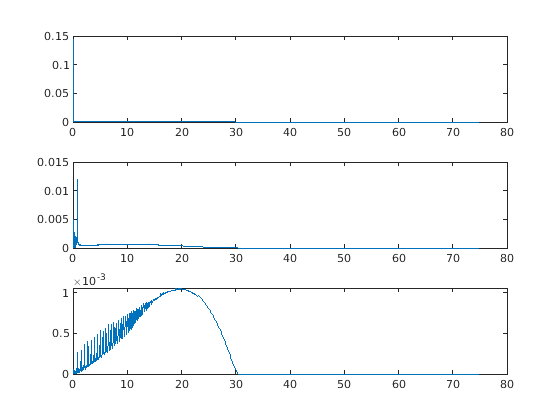

In [9]:
figure
subplot(311)
plot(grid_a_NS,dist(:,1))
subplot(312)
plot(grid_a_NS,dist(:,2))
subplot(313)
plot(grid_a_NS,dist(:,3))

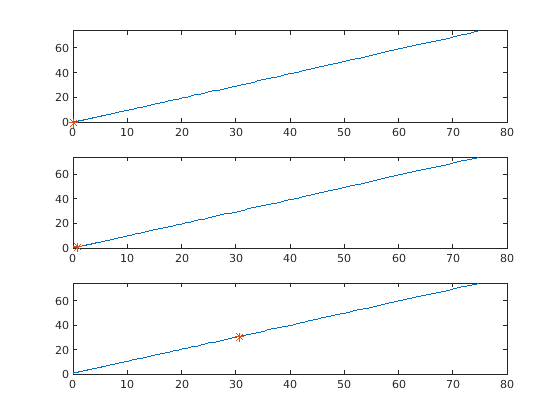

In [10]:
figure
subplot(311)
plot(grid_a,pf_sav(:,1))
hold on;
aind = min(find(pf_sav(:,1)-grid_a<=0));
ass = grid_a(aind);
plot(ass,ass,'*')
subplot(312)
plot(grid_a,pf_sav(:,2))
hold on;
aind = min(find(pf_sav(:,2)-grid_a<=0));
ass = grid_a(aind);
plot(ass,ass,'*')
subplot(313)
plot(grid_a,pf_sav(:,3))
hold on;
aind = min(find(pf_sav(:,3)-grid_a<=0));
ass = grid_a(aind);
plot(ass,ass,'*')